In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import json, os
from pathlib import Path
from torchvision import models
import numpy as np
import cv2
import torchvision.transforms as T
from torchvision.transforms import v2
import random
import torchvision.models.video as video_models
from decord import VideoReader, cpu
from VAT_model import LateFusionVAT
from LFT_model import LateFusionTransformer
from PIL import Image
import torch
import json
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import confusion_matrix

In [2]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

c:\Users\golde\Documents\UMD\CMSC498K - Multimodal Deep Learning\.venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
# -----------------------------
# VIDEO FEATURE EXTRACTOR
# -----------------------------
class VideoResNet3D(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = video_models.r3d_18(weights="DEFAULT")
        self.model.fc = nn.Linear(512, 1)  # binary classification

    def forward(self, x):
        return self.model(x).squeeze(1)

class VideoEncoder(nn.Module):
    def __init__(self, checkpoint_path, device="cuda"):
        super().__init__()

        # 1. Recreate the exact architecture used during training
        backbone = video_models.r3d_18(weights="DEFAULT")

        # Replace the classification head with identity
        backbone.fc = nn.Identity()

        # 2. Load checkpoint state_dict
        ckpt = torch.load(checkpoint_path, map_location="cpu")
        state = ckpt["model_state"]
        # Remove "model." prefix from keys
        new_state = {}
        for k, v in state.items():
            if k.startswith("model."):
                new_state[k.replace("model.", "", 1)] = v
            else:
                new_state[k] = v

        missing, unexpected = backbone.load_state_dict(new_state, strict=False)
        print("Loaded backbone. Missing keys:", missing)
        print("Unexpected keys:", unexpected)

        # 3. Freeze weights
        for p in backbone.parameters():
            p.requires_grad = False

        self.model = backbone.to(device)

    @torch.no_grad()
    def forward(self, x):
        return self.model(x)  # returns (B, 512)


In [4]:
class AudioEncoder(nn.Module):
    def __init__(self, checkpoint_path, device="cuda"):
        super().__init__()

        # 1. Recreate backbone exactly as trained
        backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Fix conv1 to accept 1-channel audio images (mel spectrograms)
        old_weight = backbone.conv1.weight.clone()
        backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        backbone.conv1.weight.data = old_weight.mean(dim=1, keepdim=True)

        # Replace FC with identity → output is 512-d
        backbone.fc = nn.Identity()

        # 2. Load checkpoint
        ckpt = torch.load(checkpoint_path, map_location="cpu")
        state = ckpt["model_state"]

        # Strip "model." prefix
        new_state = {}
        for k, v in state.items():
            if k.startswith("model."):
                new_state[k.replace("model.", "", 1)] = v
            else:
                new_state[k] = v

        missing, unexpected = backbone.load_state_dict(new_state, strict=False)
        print("Loaded Audio Encoder. Missing:", missing)
        print("Unexpected:", unexpected)

        # 3. Freeze
        for p in backbone.parameters():
            p.requires_grad = False

        self.model = backbone.to(device)

    @torch.no_grad()
    def forward(self, x):
        return self.model(x)   # (B, 512)


In [5]:
class TextEncoder(nn.Module):
    def __init__(self, checkpoint_path=None, freeze=True):
        super().__init__()

        # Rebuild same model used during training
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(768, 1)  # existed in checkpoint, but NOT used now

        if checkpoint_path is not None:
            ckpt = torch.load(checkpoint_path, map_location="cpu")
            state = ckpt["model_state"] if "model_state" in ckpt else ckpt

            missing, unexpected = self.load_state_dict(state, strict=False)
            print("Loaded text checkpoint. Missing:", missing)
            print("Unexpected:", unexpected)

        # Freeze or partially unfreeze
        if freeze:
            for p in self.bert.parameters():
                p.requires_grad = False
        else:
            # OPTIONAL: unfreeze last N transformer layers
            for p in self.bert.transformer.layer[-2:].parameters():
                p.requires_grad = True

    @torch.no_grad()
    def forward(self, input_ids, attention_mask):
        out = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0, :]  # (B, 768)

        return cls


In [6]:
def sample_frames_decord(vr, num_frames=16):
    total = len(vr)

    if total >= num_frames:
        # Convert torch tensor → Python int using .item()
        idxs = torch.linspace(0, total - 1, steps=num_frames).long().tolist()
        frames = [torch.from_numpy(vr[int(i)].asnumpy()) for i in idxs]

    else:
        frames = [torch.from_numpy(vr[i].asnumpy()) for i in range(total)]
        last = frames[-1]
        pad = num_frames - total
        frames += [last.clone() for _ in range(pad)]

    clip = torch.stack(frames)            # (T, H, W, C)
    clip = clip.permute(3, 0, 1, 2)       # (C, T, H, W)
    clip = clip.float() / 255.0
    return clip


In [7]:
class FusionDataset(Dataset):
    """
    Loads:
    - raw video (via Decord)
    - mel spectrogram image (grayscale JPG)
    - raw text transcript
    and returns all three with label.
    """

    def __init__(self, clips_json, video_transform=None, audio_transform=None, max_len=128):
        super().__init__()
        self.items = json.load(open(clips_json))
        self.video_transform = video_transform
        self.audio_transform = audio_transform
        self.max_len = max_len

        self.video_norm = T.Normalize(
            mean=[0.43216, 0.394666, 0.37645],
            std=[0.22803, 0.22145, 0.216989]
        )

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        item = self.items[idx]

        # ============================
        # VIDEO (Decord)
        # ============================
        vr = VideoReader(item["video"], ctx=cpu(0))
        clip = sample_frames_decord(vr, num_frames=16)   # (C,T,H,W)

        # Apply transform to each frame
        if self.video_transform:
            # convert to (T,C,H,W)
            frames = clip.permute(1,0,2,3)
            if self.video_transform:
                frames = torch.stack([ self.video_norm(self.video_transform(f)) for f in frames ])
            else:
                frames = torch.stack([ self.video_norm(f) for f in frames ])
            clip = frames.permute(1,0,2,3)

        # ============================
        # AUDIO (mel spectrogram image)
        # ============================
        mel_img = Image.open(item["audio_img"]).convert("L")
        mel = self.audio_transform(mel_img)
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)

        # ============================
        # TEXT
        # ============================
        with open(item["text"], "r", encoding="utf-8", errors="replace") as f:
            txt = f.read().strip()

        encoding = tokenizer(
            txt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # ============================
        # LABEL
        # ============================
        label = torch.tensor(item["highlight"], dtype=torch.float32)

        return {
            "video": clip,                    # (C,T,H,W)
            "audio": mel,                     # (1,H,W)
            "input_ids": input_ids,           # (L)
            "attention_mask": attention_mask, # (L)
            "label": label
        }

In [10]:
video_train_tf = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.4, 0.4, 0.4, 0.1),
])

video_val_tf = T.Compose([
    T.Resize((224, 224)),
])

audio_tf = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),                 # ensures (1, H, W)
])

train_dataset = FusionDataset("data/train/clips.json", video_train_tf, audio_tf)
val_dataset   = FusionDataset("data/val/clips.json", video_val_tf, audio_tf)
test_dataset  = FusionDataset("data/test/clips.json", video_val_tf, audio_tf)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False, num_workers=0)


In [11]:
len(train_loader), len(val_loader), len(test_loader)

(389, 83, 98)

In [26]:
def compute_confusion_matrix(preds, labels):
    # preds may be logits OR probabilities
    if torch.is_tensor(preds):
        preds = preds.detach().cpu().numpy()
    if torch.is_tensor(labels):
        labels = labels.detach().cpu().numpy()

    # if logits, convert to probabilities
    if preds.ndim == 1 and (preds.max() > 1 or preds.min() < 0):
        preds = 1 / (1 + np.exp(-preds))

    preds = (preds > 0.5).astype(int)
    return confusion_matrix(labels, preds, labels=[0, 1])


In [28]:
def pr_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    return precision, recall

In [31]:
@torch.no_grad()
def eval_fusion(fusion, video_enc, audio_enc, text_enc, loader, device):
    fusion.eval()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    for batch in pbar:
        video = batch["video"].to(device)
        audio = batch["audio"].to(device)
        ids   = batch["input_ids"].to(device)
        mask  = batch["attention_mask"].to(device)
        label = batch["label"].to(device)

        v = F.normalize(video_enc(video), dim=1)
        a = F.normalize(audio_enc(audio), dim=1)
        t = F.normalize(text_enc(ids, mask), dim=1)

        out    = fusion(v, a, t, label)
        logits = out["logits"]
        loss   = out["loss"]

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        total_loss += loss.item() * label.size(0)
        total_correct += (preds == label).sum().item()
        total_samples += label.size(0)

        all_preds.append(probs.cpu())
        all_labels.append(label.cpu())

    # stack for confusion matrix
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    cm = compute_confusion_matrix(all_preds, all_labels)

    return total_loss / total_samples, total_correct / total_samples, cm


In [30]:
def train_fusion(fusion, video_enc, audio_enc, text_enc,
                 train_loader, val_loader,
                 optimizer, scheduler, device,
                 save_dir="fusion_checkpoints",
                 ckpt_file="fusion.pt",
                 history_file="history.json",
                 epochs=10):

    os.makedirs(save_dir, exist_ok=True)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "lr": [],
        "confusion_train": [],
        "confusion_val": []
    }

    best_val_acc = 0.0

    for ep in range(1, epochs + 1):

        # ==========================
        # TRAINING
        # ==========================
        fusion.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        pbar = tqdm(train_loader, desc=f"Epoch {ep}/{epochs} - Training", leave=True)

        all_preds, all_labels = [], []

        for batch in pbar:
            video = batch["video"].to(device)
            audio = batch["audio"].to(device)
            ids   = batch["input_ids"].to(device)
            mask  = batch["attention_mask"].to(device)
            label = batch["label"].to(device)

            # frozen encoders
            with torch.no_grad():
                v = F.normalize(video_enc(video), dim=1)
                a = F.normalize(audio_enc(audio), dim=1)
                t = F.normalize(text_enc(ids, mask), dim=1)

            out = fusion(v, a, t, label)
            loss = out["loss"]
            logits = out["logits"]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            total_loss += loss.item() * label.size(0)
            total_correct += (preds == label).sum().item()
            total_samples += label.size(0)

            all_preds.append(probs.cpu())
            all_labels.append(label.cpu())

            pbar.set_postfix({"loss": loss.item()})

        train_loss = total_loss / total_samples
        train_acc = total_correct / total_samples

        # confusion matrix for train
        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        cm_train = compute_confusion_matrix(all_preds, all_labels)

        # ==========================
        # VALIDATION
        # ==========================
        val_loss, val_acc, cm_val = eval_fusion(
            fusion, video_enc, audio_enc, text_enc, val_loader, device
        )

        # step LR
        scheduler.step()

        # ==========================
        # LOGGING
        # ==========================
        train_prec, train_rec = pr_from_cm(cm_train)
        val_prec,   val_rec   = pr_from_cm(cm_val)

        print(f"\nEpoch {ep}/{epochs} — Results:")
        print(f"Train Loss: {train_loss:.4f}  | Train Acc: {train_acc:.4f}  | "
            f"Train Prec: {train_prec:.4f}  | Train Rec: {train_rec:.4f}")
        print(f"Val Loss: {val_loss:.4f}    | Val Acc: {val_acc:.4f}    | "
            f"Val Prec: {val_prec:.4f}    | Val Rec: {val_rec:.4f}")
        print("Confusion Matrix (Train):")
        print(cm_train)
        print("Confusion Matrix (Val):")
        print(cm_val)

        # save to history
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(optimizer.param_groups[0]["lr"])
        history["confusion_train"].append(cm_train.tolist())
        history["confusion_val"].append(cm_val.tolist())

        # ==========================
        # SAVE BEST CHECKPOINT
        # ==========================
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ckpt_path = os.path.join(save_dir, ckpt_file)

            torch.save({
                "epoch": ep,
                "fusion_state": fusion.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "scheduler_state": scheduler.state_dict(),
                "val_acc": val_acc
            }, ckpt_path)

            print(f"🔥 Saved new best model: {ckpt_path}")

        # write history each epoch
        with open(os.path.join(save_dir, history_file), "w") as f:
            json.dump(history, f, indent=2)

    print("\n🏁 Training complete!")
    return history


In [29]:
@torch.no_grad()
def test_fusion(fusion, video_enc, audio_enc, text_enc,
                test_loader, device):

    test_loss, test_acc, cm = eval_fusion(
        fusion, video_enc, audio_enc, text_enc, test_loader, device
    )

    test_prec, test_rec = pr_from_cm(cm)

    print("===== TEST RESULTS =====")
    print(f"Loss: {test_loss:.4f}")
    print(f"Acc : {test_acc:.4f}")
    print(f"Prec: {test_prec:.4f}")
    print(f"Rec : {test_rec:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return test_loss, test_acc, cm


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_enc = VideoEncoder("ckpts/video_model.pt").to(device)
audio_enc = AudioEncoder("ckpts/audio_model.pt").to(device)
text_enc  = TextEncoder("ckpts/text_model.pt").to(device)


Loaded backbone. Missing keys: []
Unexpected keys: ['fc.weight', 'fc.bias']
Loaded Audio Encoder. Missing: []
Unexpected: ['fc.weight', 'fc.bias']
Loaded text checkpoint. Missing: []
Unexpected: []


In [32]:
fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="concat",
    hidden_dim=256
).to(device)

optimizer = torch.optim.Adam(fusion.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) 

In [18]:
history = train_fusion(
    fusion, video_enc, audio_enc, text_enc,
    train_loader, val_loader,
    optimizer, scheduler,
    device,
    save_dir="ckpts",
    ckpt_file="concat_fusion.pt",
    history_file="concat_history.json",
    epochs=10
)

Epoch 1/10 - Training: 100%|██████████| 778/778 [10:21<00:00,  1.25it/s, loss=0.000519]



Epoch 1/10 — Results:
Train Loss: 0.0766  | Train Acc: 0.9730
Val Loss:   0.5448    | Val Acc:   0.8524
Confusion Matrix (Train):
[[2465   36]
 [  48  562]]
Confusion Matrix (Val):
[[508  14]
 [ 84  58]]
🔥 Saved new best model: ckpts\concat_fusion.pt


Epoch 2/10 - Training: 100%|██████████| 778/778 [10:21<00:00,  1.25it/s, loss=0.206]   



Epoch 2/10 — Results:
Train Loss: 0.0681  | Train Acc: 0.9756
Val Loss:   0.5236    | Val Acc:   0.8494
Confusion Matrix (Train):
[[2468   33]
 [  43  567]]
Confusion Matrix (Val):
[[496  26]
 [ 74  68]]


Epoch 3/10 - Training: 100%|██████████| 778/778 [10:25<00:00,  1.24it/s, loss=0.00095] 



Epoch 3/10 — Results:
Train Loss: 0.0638  | Train Acc: 0.9772
Val Loss:   0.5670    | Val Acc:   0.8464
Confusion Matrix (Train):
[[2473   28]
 [  43  567]]
Confusion Matrix (Val):
[[493  29]
 [ 73  69]]


Epoch 4/10 - Training: 100%|██████████| 778/778 [10:16<00:00,  1.26it/s, loss=0.0427]  



Epoch 4/10 — Results:
Train Loss: 0.0575  | Train Acc: 0.9810
Val Loss:   0.4814    | Val Acc:   0.8419
Confusion Matrix (Train):
[[2474   27]
 [  32  578]]
Confusion Matrix (Val):
[[471  51]
 [ 54  88]]


Epoch 5/10 - Training: 100%|██████████| 778/778 [10:18<00:00,  1.26it/s, loss=0.0467]  



Epoch 5/10 — Results:
Train Loss: 0.0536  | Train Acc: 0.9817
Val Loss:   0.5111    | Val Acc:   0.8404
Confusion Matrix (Train):
[[2477   24]
 [  33  577]]
Confusion Matrix (Val):
[[483  39]
 [ 67  75]]


Epoch 6/10 - Training: 100%|██████████| 778/778 [10:20<00:00,  1.25it/s, loss=0.00493] 



Epoch 6/10 — Results:
Train Loss: 0.0470  | Train Acc: 0.9859
Val Loss:   0.5648    | Val Acc:   0.8509
Confusion Matrix (Train):
[[2482   19]
 [  25  585]]
Confusion Matrix (Val):
[[500  22]
 [ 77  65]]


Epoch 7/10 - Training: 100%|██████████| 778/778 [10:23<00:00,  1.25it/s, loss=0.00151] 



Epoch 7/10 — Results:
Train Loss: 0.0473  | Train Acc: 0.9830
Val Loss:   0.5435    | Val Acc:   0.8524
Confusion Matrix (Train):
[[2477   24]
 [  29  581]]
Confusion Matrix (Val):
[[498  24]
 [ 74  68]]


Epoch 8/10 - Training: 100%|██████████| 778/778 [19:20<00:00,  1.49s/it, loss=0.238]   



Epoch 8/10 — Results:
Train Loss: 0.0421  | Train Acc: 0.9842
Val Loss:   0.5276    | Val Acc:   0.8494
Confusion Matrix (Train):
[[2479   22]
 [  27  583]]
Confusion Matrix (Val):
[[492  30]
 [ 70  72]]


Epoch 9/10 - Training: 100%|██████████| 778/778 [10:22<00:00,  1.25it/s, loss=0.00128] 



Epoch 9/10 — Results:
Train Loss: 0.0424  | Train Acc: 0.9852
Val Loss:   0.5257    | Val Acc:   0.8479
Confusion Matrix (Train):
[[2481   20]
 [  26  584]]
Confusion Matrix (Val):
[[491  31]
 [ 70  72]]


Epoch 10/10 - Training: 100%|██████████| 778/778 [10:33<00:00,  1.23it/s, loss=0.00546] 
                                                             


Epoch 10/10 — Results:
Train Loss: 0.0414  | Train Acc: 0.9865
Val Loss:   0.5257    | Val Acc:   0.8479
Confusion Matrix (Train):
[[2480   21]
 [  21  589]]
Confusion Matrix (Val):
[[491  31]
 [ 70  72]]

🏁 Training complete!


In [19]:
with open("ckpts/concat_history.json", "r") as f:
    history = json.load(f)

print("Loaded history keys:", history.keys())

Loaded history keys: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'confusion_train', 'confusion_val'])


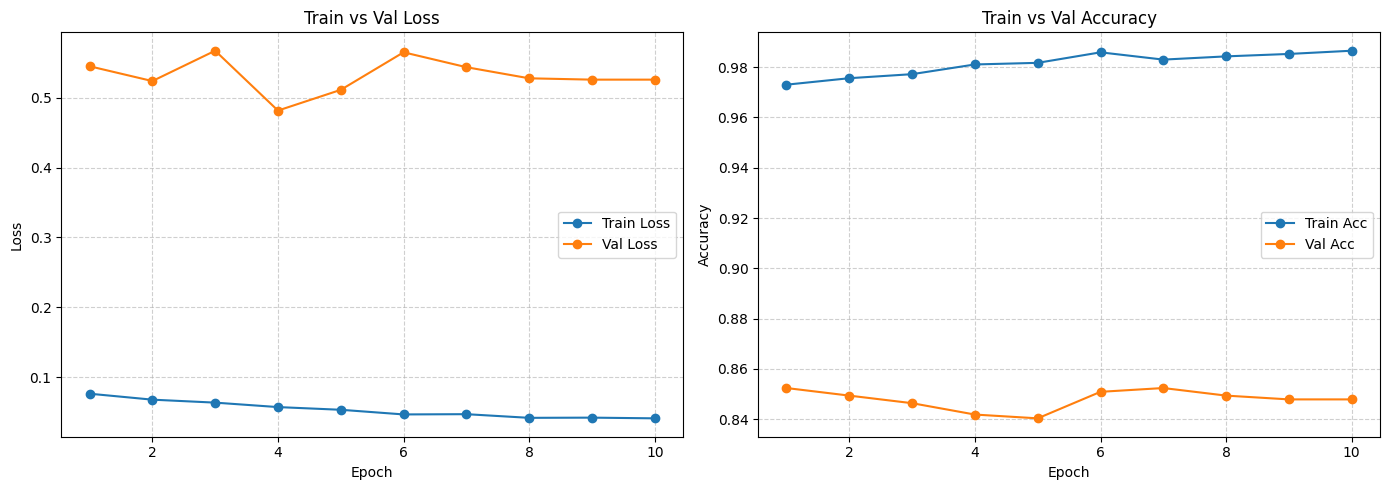

In [20]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
train_acc  = history["train_acc"]
val_acc    = history["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14,5))

# -------------------------
# Loss Plot
# -------------------------
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# -------------------------
# Accuracy Plot
# -------------------------
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [21]:
test_fusion(fusion, video_enc, audio_enc, text_enc, test_loader, device)

===== TEST RESULTS =====
Loss: 0.5310
Acc : 0.8533
Confusion Matrix:
[[597  22]
 [ 92  66]]


(0.5309620393548602,
 0.8532818532818532,
 array([[597,  22],
        [ 92,  66]]))

In [71]:
attn_fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="attention",
    hidden_dim=256,
).to(device)

optimizer = torch.optim.Adam(attn_fusion.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=8) 

In [72]:
history = train_fusion(
    attn_fusion, video_enc, audio_enc, text_enc,
    train_loader, val_loader,
    optimizer, scheduler,
    device,
    save_dir="ckpts",
    ckpt_file="attn_fusion.pt",
    history_file="attn_history.json",
    epochs=8
)

Epoch 1/8 - Training: 100%|██████████| 778/778 [10:54<00:00,  1.19it/s, loss=0.00484] 



Epoch 1/8 — Results:
Train Loss: 0.1366  | Train Acc: 0.9454
Val Loss:   0.4537    | Val Acc:   0.8599
Confusion Matrix (Train):
[[2471   30]
 [ 140  470]]
Confusion Matrix (Val):
[[495  27]
 [ 66  76]]
🔥 Saved new best model: ckpts\attn_fusion.pt


Epoch 2/8 - Training: 100%|██████████| 778/778 [11:03<00:00,  1.17it/s, loss=0.00339] 



Epoch 2/8 — Results:
Train Loss: 0.0787  | Train Acc: 0.9727
Val Loss:   0.4405    | Val Acc:   0.8509
Confusion Matrix (Train):
[[2467   34]
 [  51  559]]
Confusion Matrix (Val):
[[493  29]
 [ 70  72]]


Epoch 3/8 - Training: 100%|██████████| 778/778 [11:08<00:00,  1.16it/s, loss=0.00309] 



Epoch 3/8 — Results:
Train Loss: 0.0669  | Train Acc: 0.9788
Val Loss:   0.4045    | Val Acc:   0.8539
Confusion Matrix (Train):
[[2477   24]
 [  42  568]]
Confusion Matrix (Val):
[[489  33]
 [ 64  78]]


Epoch 4/8 - Training: 100%|██████████| 778/778 [10:45<00:00,  1.20it/s, loss=0.0776]  



Epoch 4/8 — Results:
Train Loss: 0.0640  | Train Acc: 0.9810
Val Loss:   0.4579    | Val Acc:   0.8524
Confusion Matrix (Train):
[[2477   24]
 [  35  575]]
Confusion Matrix (Val):
[[494  28]
 [ 70  72]]


Epoch 5/8 - Training: 100%|██████████| 778/778 [10:45<00:00,  1.21it/s, loss=0.124]   



Epoch 5/8 — Results:
Train Loss: 0.0576  | Train Acc: 0.9817
Val Loss:   0.5515    | Val Acc:   0.8524
Confusion Matrix (Train):
[[2481   20]
 [  37  573]]
Confusion Matrix (Val):
[[499  23]
 [ 75  67]]


Epoch 6/8 - Training: 100%|██████████| 778/778 [10:48<00:00,  1.20it/s, loss=8.13e-6] 



Epoch 6/8 — Results:
Train Loss: 0.0525  | Train Acc: 0.9814
Val Loss:   0.5923    | Val Acc:   0.8449
Confusion Matrix (Train):
[[2483   18]
 [  40  570]]
Confusion Matrix (Val):
[[496  26]
 [ 77  65]]


Epoch 7/8 - Training: 100%|██████████| 778/778 [10:46<00:00,  1.20it/s, loss=0.000638]



Epoch 7/8 — Results:
Train Loss: 0.0462  | Train Acc: 0.9833
Val Loss:   0.5899    | Val Acc:   0.8479
Confusion Matrix (Train):
[[2487   14]
 [  38  572]]
Confusion Matrix (Val):
[[491  31]
 [ 70  72]]


Epoch 8/8 - Training: 100%|██████████| 778/778 [10:44<00:00,  1.21it/s, loss=0.000498]
                                                             


Epoch 8/8 — Results:
Train Loss: 0.0509  | Train Acc: 0.9817
Val Loss:   0.5832    | Val Acc:   0.8494
Confusion Matrix (Train):
[[2481   20]
 [  37  573]]
Confusion Matrix (Val):
[[492  30]
 [ 70  72]]

🏁 Training complete!


In [73]:
with open("ckpts/attn_history.json", "r") as f:
    history = json.load(f)

print("Loaded history keys:", history.keys())

Loaded history keys: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'confusion_train', 'confusion_val'])


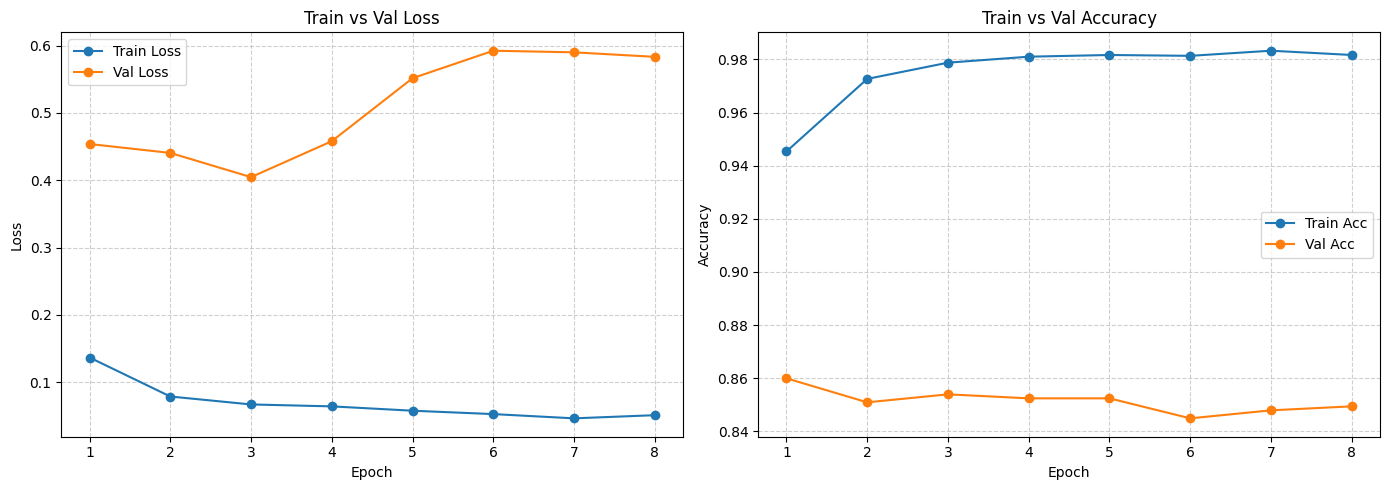

In [74]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
train_acc  = history["train_acc"]
val_acc    = history["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14,5))

# -------------------------
# Loss Plot
# -------------------------
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# -------------------------
# Accuracy Plot
# -------------------------
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [75]:
test_fusion(attn_fusion, video_enc, audio_enc, text_enc, test_loader, device)

===== TEST RESULTS =====
Loss: 0.5655
Acc : 0.8546
Confusion Matrix:
[[598  21]
 [ 92  66]]


(0.5655492177856978,
 0.8545688545688546,
 array([[598,  21],
        [ 92,  66]]))

In [ ]:
logits_fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="logits",
    hidden_dim=256,
).to(device)

optimizer = torch.optim.Adam(logits_fusion.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6) 

In [38]:
history = train_fusion(
    logits_fusion, video_enc, audio_enc, text_enc,
    train_loader, val_loader,
    optimizer, scheduler,
    device,
    save_dir="ckpts",
    ckpt_file="logits_fusion.pt",
    history_file="logits_history.json",
    epochs=6
)

Epoch 1/6 - Training: 100%|██████████| 778/778 [10:51<00:00,  1.20it/s, loss=0.0289]



Epoch 1/6 — Results:
Train Loss: 0.2239  | Train Acc: 0.9142
Val Loss:   0.3503    | Val Acc:   0.8373
Confusion Matrix (Train):
[[2489   12]
 [ 255  355]]
Confusion Matrix (Val):
[[500  22]
 [ 86  56]]
🔥 Saved new best model: ckpts\logits_fusion.pt


Epoch 2/6 - Training: 100%|██████████| 778/778 [10:16<00:00,  1.26it/s, loss=0.0392] 



Epoch 2/6 — Results:
Train Loss: 0.1040  | Train Acc: 0.9695
Val Loss:   0.3938    | Val Acc:   0.8373
Confusion Matrix (Train):
[[2478   23]
 [  72  538]]
Confusion Matrix (Val):
[[497  25]
 [ 83  59]]


Epoch 3/6 - Training: 100%|██████████| 778/778 [10:20<00:00,  1.25it/s, loss=0.0941] 



Epoch 3/6 — Results:
Train Loss: 0.0908  | Train Acc: 0.9691
Val Loss:   0.4090    | Val Acc:   0.8509
Confusion Matrix (Train):
[[2471   30]
 [  66  544]]
Confusion Matrix (Val):
[[493  29]
 [ 70  72]]
🔥 Saved new best model: ckpts\logits_fusion.pt


Epoch 4/6 - Training: 100%|██████████| 778/778 [10:16<00:00,  1.26it/s, loss=0.115]  



Epoch 4/6 — Results:
Train Loss: 0.0876  | Train Acc: 0.9662
Val Loss:   0.4175    | Val Acc:   0.8524
Confusion Matrix (Train):
[[2464   37]
 [  68  542]]
Confusion Matrix (Val):
[[491  31]
 [ 67  75]]
🔥 Saved new best model: ckpts\logits_fusion.pt


Epoch 5/6 - Training: 100%|██████████| 778/778 [10:22<00:00,  1.25it/s, loss=0.00128]



Epoch 5/6 — Results:
Train Loss: 0.0822  | Train Acc: 0.9720
Val Loss:   0.4261    | Val Acc:   0.8479
Confusion Matrix (Train):
[[2465   36]
 [  51  559]]
Confusion Matrix (Val):
[[491  31]
 [ 70  72]]


Epoch 6/6 - Training: 100%|██████████| 778/778 [10:13<00:00,  1.27it/s, loss=0.0016] 
                                                             


Epoch 6/6 — Results:
Train Loss: 0.0806  | Train Acc: 0.9720
Val Loss:   0.4274    | Val Acc:   0.8479
Confusion Matrix (Train):
[[2469   32]
 [  55  555]]
Confusion Matrix (Val):
[[491  31]
 [ 70  72]]

🏁 Training complete!


In [39]:
with open("ckpts/logits_history.json", "r") as f:
    history = json.load(f)

print("Loaded history keys:", history.keys())

Loaded history keys: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'confusion_train', 'confusion_val'])


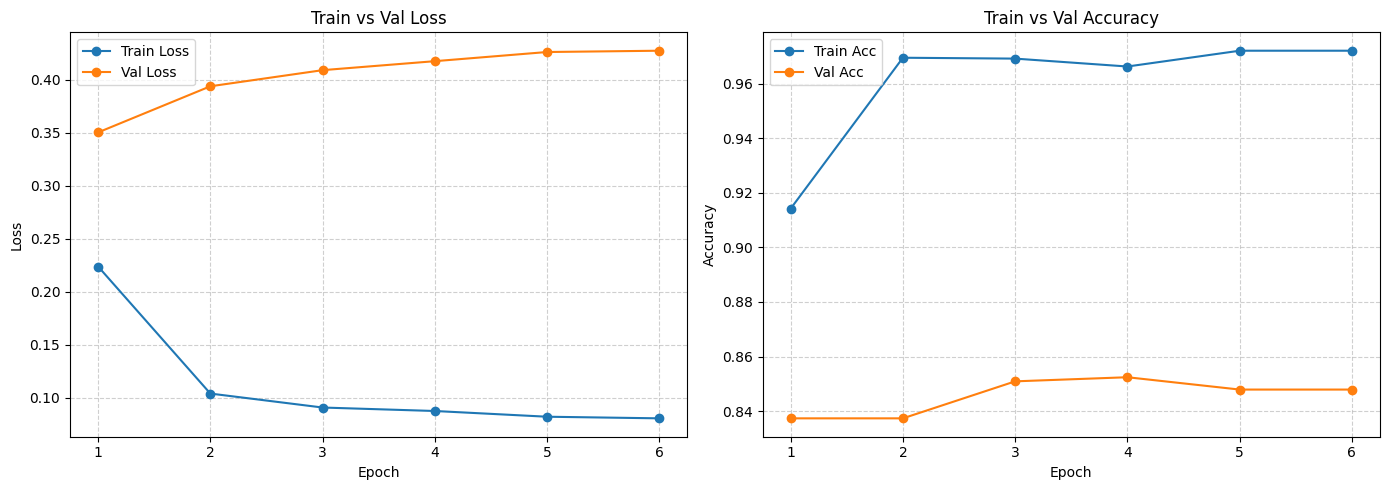

In [40]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
train_acc  = history["train_acc"]
val_acc    = history["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14,5))

# -------------------------
# Loss Plot
# -------------------------
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# -------------------------
# Accuracy Plot
# -------------------------
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [41]:
test_fusion(logits_fusion, video_enc, audio_enc, text_enc, test_loader, device)

===== TEST RESULTS =====
Loss: 0.3921
Acc : 0.8533
Confusion Matrix:
[[597  22]
 [ 92  66]]


(0.3920833523932993,
 0.8532818532818532,
 array([[597,  22],
        [ 92,  66]]))

In [34]:
transformer_fusion = LateFusionTransformer(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    hidden_dim=256,
).to(device)

optimizer = torch.optim.AdamW(transformer_fusion.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=6) 

In [35]:
history = train_fusion(
    transformer_fusion, video_enc, audio_enc, text_enc,
    train_loader, val_loader,
    optimizer, scheduler,
    device,
    save_dir="ckpts",
    ckpt_file="transformer_fusion2.pt",
    history_file="transformer_history2.json",
    epochs=6
)

Epoch 1/6 - Training: 100%|██████████| 389/389 [12:58<00:00,  2.00s/it, loss=0.0132] 



Epoch 1/6 — Results:
Train Loss: 0.2441  | Train Acc: 0.9479  | Train Prec: 0.8522  | Train Rec: 0.8885
Val Loss: 1.6118    | Val Acc: 0.8404    | Val Prec: 0.8214    | Val Rec: 0.3239
Confusion Matrix (Train):
[[2407   94]
 [  68  542]]
Confusion Matrix (Val):
[[512  10]
 [ 96  46]]
🔥 Saved new best model: ckpts\transformer_fusion2.pt


Epoch 2/6 - Training: 100%|██████████| 389/389 [13:06<00:00,  2.02s/it, loss=0.0172] 



Epoch 2/6 — Results:
Train Loss: 0.1486  | Train Acc: 0.9662  | Train Prec: 0.8832  | Train Rec: 0.9541
Val Loss: 0.8163    | Val Acc: 0.8404    | Val Prec: 0.6047    | Val Rec: 0.7324
Confusion Matrix (Train):
[[2424   77]
 [  28  582]]
Confusion Matrix (Val):
[[454  68]
 [ 38 104]]


Epoch 3/6 - Training: 100%|██████████| 389/389 [12:57<00:00,  2.00s/it, loss=0.156]  



Epoch 3/6 — Results:
Train Loss: 0.1179  | Train Acc: 0.9724  | Train Prec: 0.8994  | Train Rec: 0.9672
Val Loss: 1.3246    | Val Acc: 0.8464    | Val Prec: 0.7083    | Val Rec: 0.4789
Confusion Matrix (Train):
[[2435   66]
 [  20  590]]
Confusion Matrix (Val):
[[494  28]
 [ 74  68]]
🔥 Saved new best model: ckpts\transformer_fusion2.pt


Epoch 4/6 - Training: 100%|██████████| 389/389 [12:39<00:00,  1.95s/it, loss=0.0039] 



Epoch 4/6 — Results:
Train Loss: 0.0858  | Train Acc: 0.9788  | Train Prec: 0.9211  | Train Rec: 0.9754
Val Loss: 1.4273    | Val Acc: 0.8539    | Val Prec: 0.7064    | Val Rec: 0.5423
Confusion Matrix (Train):
[[2450   51]
 [  15  595]]
Confusion Matrix (Val):
[[490  32]
 [ 65  77]]
🔥 Saved new best model: ckpts\transformer_fusion2.pt


Epoch 5/6 - Training: 100%|██████████| 389/389 [12:58<00:00,  2.00s/it, loss=0.0559] 



Epoch 5/6 — Results:
Train Loss: 0.0831  | Train Acc: 0.9817  | Train Prec: 0.9300  | Train Rec: 0.9803
Val Loss: 1.0999    | Val Acc: 0.8479    | Val Prec: 0.6496    | Val Rec: 0.6268
Confusion Matrix (Train):
[[2456   45]
 [  12  598]]
Confusion Matrix (Val):
[[474  48]
 [ 53  89]]


Epoch 6/6 - Training: 100%|██████████| 389/389 [12:36<00:00,  1.94s/it, loss=0.318]  
                                                           


Epoch 6/6 — Results:
Train Loss: 0.0717  | Train Acc: 0.9833  | Train Prec: 0.9306  | Train Rec: 0.9885
Val Loss: 1.3952    | Val Acc: 0.8464    | Val Prec: 0.6961    | Val Rec: 0.5000
Confusion Matrix (Train):
[[2456   45]
 [   7  603]]
Confusion Matrix (Val):
[[491  31]
 [ 71  71]]

🏁 Training complete!


In [36]:
with open("ckpts/transformer_history2.json", "r") as f:
    history = json.load(f)

print("Loaded history keys:", history.keys())

Loaded history keys: dict_keys(['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr', 'confusion_train', 'confusion_val'])


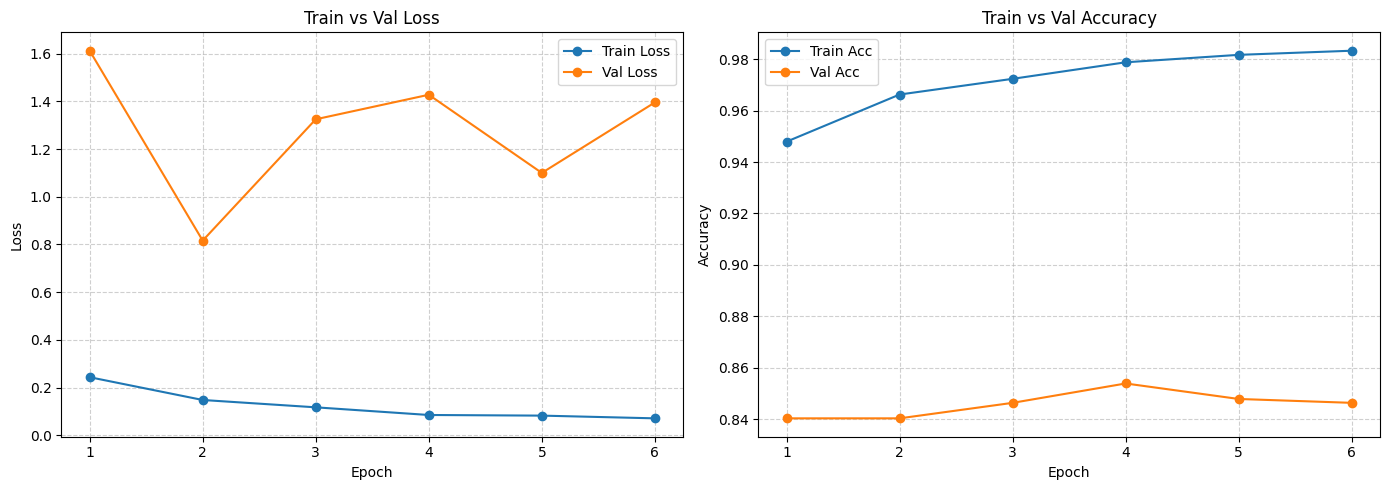

In [ ]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss   = history["val_loss"]
train_acc  = history["train_acc"]
val_acc    = history["val_acc"]

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(14,5))

# -------------------------
# Loss Plot
# -------------------------
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# -------------------------
# Accuracy Plot
# -------------------------
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
test_fusion(transformer_fusion, video_enc, audio_enc, text_enc, test_loader, device)

===== TEST RESULTS =====
Loss: 1.4711
Acc : 0.8559
Prec: 0.7500
Rec : 0.4367
Confusion Matrix:
[[596  23]
 [ 89  69]]


(1.4711431868522975,
 0.8558558558558559,
 array([[596,  23],
        [ 89,  69]]))

In [42]:
# 1) Recreate the fusion model with SAME dims as training
loaded_fusion = LateFusionTransformer(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    hidden_dim=256,
).to(device)

# 2) Load checkpoint
ckpt = torch.load("ckpts/transformer_fusion.pt", map_location=device)
loaded_fusion.load_state_dict(ckpt["fusion_state"])
print("Loaded fusion checkpoint from epoch", ckpt["epoch"],
      "val_acc:", ckpt.get("val_acc", "N/A"),
      "val_rec:", ckpt.get("val_rec", "N/A"))

# 3) Run on test set
test_loss, test_acc, cm = test_fusion(
    loaded_fusion,
    video_enc,
    audio_enc,
    text_enc,
    test_loader,
    device,
)

Loaded fusion checkpoint from epoch 3 val_acc: 0.8524096385542169 val_rec: N/A


===== TEST RESULTS =====
Loss: 1.1275
Acc : 0.8662
Prec: 0.7368
Rec : 0.5316
Confusion Matrix:
[[589  30]
 [ 74  84]]


In [51]:
# 1) Recreate the fusion model with SAME dims as training
loaded_fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="logits",
    hidden_dim=256,
).to(device)

# 2) Load checkpoint"
ckpt = torch.load("ckpts/logits_fusion.pt", map_location=device)
loaded_fusion.load_state_dict(ckpt["fusion_state"], strict=False)
print("Loaded fusion checkpoint from epoch", ckpt["epoch"],
      "val_acc:", ckpt.get("val_acc", "N/A"),
      "val_rec:", ckpt.get("val_rec", "N/A"))

# 3) Run on test set
test_loss, test_acc, cm = test_fusion(
    loaded_fusion,
    video_enc,
    audio_enc,
    text_enc,
    test_loader,
    device,
)

Loaded fusion checkpoint from epoch 4 val_acc: 0.8524096385542169 val_rec: N/A


===== TEST RESULTS =====
Loss: 0.8746
Acc : 0.8610
Prec: 0.8472
Rec : 0.3861
Confusion Matrix:
[[608  11]
 [ 97  61]]


In [50]:
# 1) Recreate the fusion model with SAME dims as training
loaded_fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="attention",
    hidden_dim=256,
).to(device)

# 2) Load checkpoint
ckpt = torch.load("ckpts/attn_fusion.pt", map_location=device)
loaded_fusion.load_state_dict(ckpt["fusion_state"], strict=False)
print("Loaded fusion checkpoint from epoch", ckpt["epoch"],
      "val_acc:", ckpt.get("val_acc", "N/A"),
      "val_rec:", ckpt.get("val_rec", "N/A"))

# 3) Run on test set
test_loss, test_acc, cm = test_fusion(
    loaded_fusion,
    video_enc,
    audio_enc,
    text_enc,
    test_loader,
    device,
)

Loaded fusion checkpoint from epoch 1 val_acc: 0.8599397590361446 val_rec: N/A


===== TEST RESULTS =====
Loss: 1.0584
Acc : 0.8700
Prec: 0.8065
Rec : 0.4747
Confusion Matrix:
[[601  18]
 [ 83  75]]


In [52]:
# 1) Recreate the fusion model with SAME dims as training
loaded_fusion = LateFusionVAT(
    video_dim=512,
    audio_dim=512,
    text_dim=768,
    fusion_type="concat",
    hidden_dim=256,
).to(device)

# 2) Load checkpoint"
ckpt = torch.load("ckpts/concat_fusion.pt", map_location=device)
loaded_fusion.load_state_dict(ckpt["fusion_state"], strict=False)
print("Loaded fusion checkpoint from epoch", ckpt["epoch"],
      "val_acc:", ckpt.get("val_acc", "N/A"),
      "val_rec:", ckpt.get("val_rec", "N/A"))

# 3) Run on test set
test_loss, test_acc, cm = test_fusion(
    loaded_fusion,
    video_enc,
    audio_enc,
    text_enc,
    test_loader,
    device,
)

Loaded fusion checkpoint from epoch 1 val_acc: 0.8524096385542169 val_rec: N/A


===== TEST RESULTS =====
Loss: 0.8612
Acc : 0.8533
Prec: 0.8235
Rec : 0.3544
Confusion Matrix:
[[607  12]
 [102  56]]
